### Linear and Polynomical Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import warnings
# Surpress warnings
def warn(*args, **kwargs):
    pass

warnings.warn = warn

# %matplotlib inline
# sns.set_style(style='whitegrid')
# sns.set_context(context='notebook')
# plt.rcParams['figure.figsize'] = (10, 8)


In [2]:
# Download data
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/encoded_car_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   diesel       205 non-null    float64
 1   gas          205 non-null    float64
 2   std          205 non-null    float64
 3   turbo        205 non-null    float64
 4   convertible  205 non-null    float64
 5   hardtop      205 non-null    float64
 6   hatchback    205 non-null    float64
 7   sedan        205 non-null    float64
 8   wagon        205 non-null    float64
 9   4wd          205 non-null    float64
 10  fwd          205 non-null    float64
 11  rwd          205 non-null    float64
 12  dohc         205 non-null    float64
 13  dohcv        205 non-null    float64
 14  l            205 non-null    float64
 15  ohc          205 non-null    float64
 16  ohcf         205 non-null    float64
 17  ohcv         205 non-null    float64
 18  rotor        205 non-null    float64
 19  eight   

We have 35 features in our dataset after the one hot encoding.

Before we begin our polynomial analysis, let's visualize some of the relationships between our features and the target variable, 'price'.

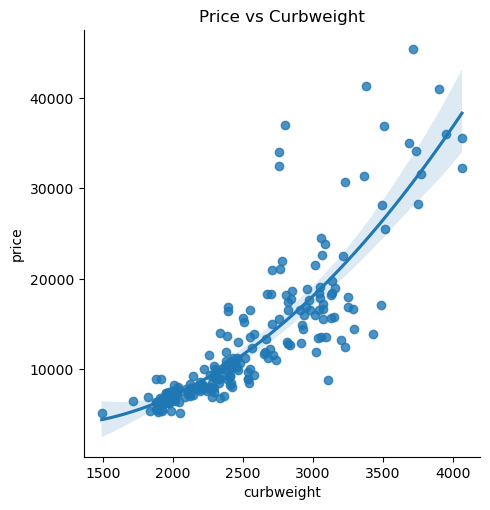

In [4]:
sns.lmplot(x='curbweight', y='price', data=df, order=2)
plt.title('Price vs Curbweight')
plt.show()

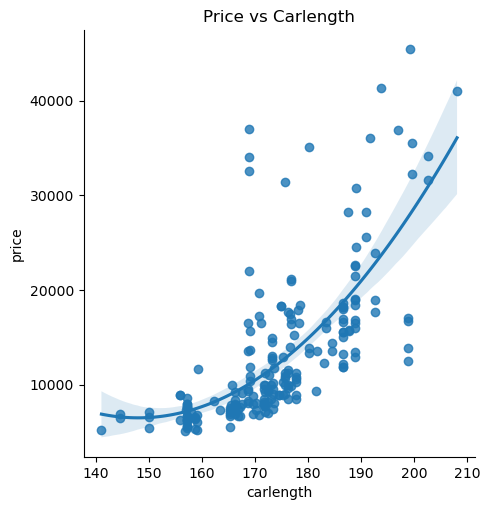

In [5]:
sns.lmplot(x='carlength', y='price', data=df, order=2)
plt.title('Price vs Carlength')
plt.show()

The relationship is more curved.

### Data preparation

In [6]:
# Let's split our data into X features and y target
X = df.drop('price', axis=1)
y = df.price

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [7]:
print(f'Number of test samples: {X_test.shape[0]}')
print(f'Number of training samples: {X_train.shape[0]}')

Number of test samples: 62
Number of training samples: 143


In [8]:
# Let's create a LinearRegresion object, called lm
lm = LinearRegression()

# Let's fit the model with multiple features on our X_train and y_train data.
lm.fit(X_train, y_train)

# we apply predict() function on testin data set.add
predicted = lm.predict(X_test)

In [9]:
# Lets calculate r2_score() on both, training and testing data sets. 
print(f'R² on training data: {lm.score(X_train, y_train)}')
print(f'R² on testing data: {lm.score(X_test, y_test)}')

R² on training data: 0.9260519911659063
R² on testing data: 0.8488476500423834


In [10]:
# We can plot distribution of the predicted values vs the actual values
def plot_dist(y,yhat):
    sns.kdeplot(y, color='r', label='Actual Value')
    sns.kdeplot(yhat, color='b', label='Fitted Value')

    plt.legend()
    plt.title('Actual vs Fited Values')
    plt.xlabel('Price USD')
    plt.ylabel('Proportion of Cars')
    plt.show()
    plt.close()

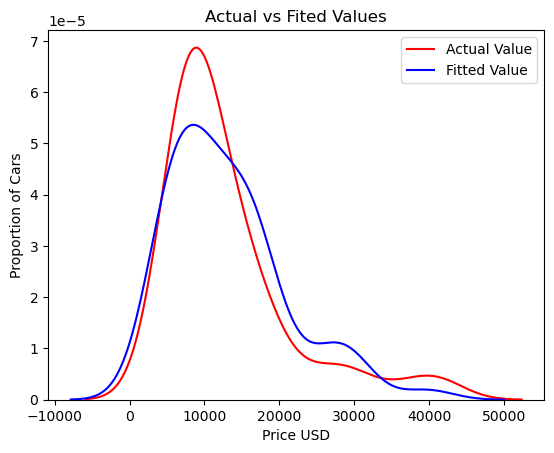

In [11]:
plot_dist(y_test, predicted)

Below, we will view the estimated coefficients for the linear regression problem.

In [12]:
{col:coef for col, coef in zip(X.columns, lm.coef_)}

{'diesel': 831913222608671.2,
 'gas': 831913222607230.4,
 'std': 265.817138671875,
 'turbo': -264.91015625,
 'convertible': 1772.9595489501953,
 'hardtop': 3023.3792724609375,
 'hatchback': -1723.89794921875,
 'sedan': -619.0015869140625,
 'wagon': -2452.8715209960938,
 '4wd': -568.2215728759766,
 'fwd': -232.0255126953125,
 'rwd': 855.8648681640625,
 'dohc': 2472.438751220703,
 'dohcv': -13345.657196044922,
 'l': 2227.9989013671875,
 'ohc': 4688.209747314453,
 'ohcf': 6033.189788818359,
 'ohcv': -2810.8487548828125,
 'rotor': 726.4886322021484,
 'eight': 9304.24674987793,
 'five': -2735.461212158203,
 'four': -5352.745178222656,
 'six': -2151.5219116210938,
 'three': 0.0,
 'twelve': 208.89024353027344,
 'two': 726.4573822021484,
 'wheelbase': 77.236328125,
 'curbweight': 5.125,
 'enginesize': 23.912109375,
 'boreratio': -1786.1702728271484,
 'horsepower': 69.234375,
 'carlength': -63.23828125,
 'carwidth': 575.81005859375,
 'citympg': -161.779296875,
 'highwaympg': 145.765625}

As we see, the first two coefficients are too large to plot, so we'll drop them and plot the rest of the coefficients.

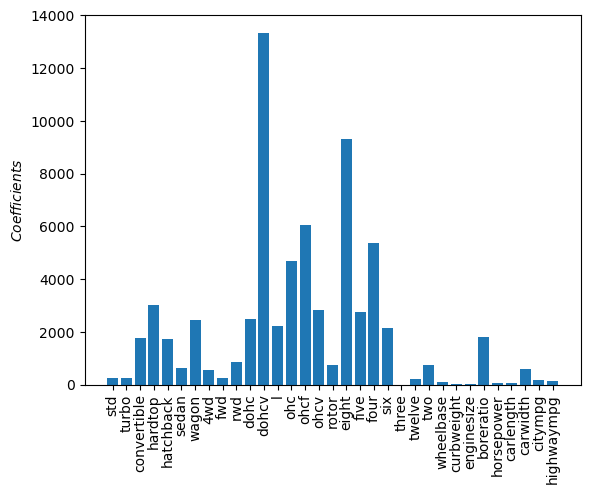

In [13]:
#Plotting coefficients
plt.bar(X.columns[2:], abs(lm.coef_[2:]))

plt.title('')
plt.xticks(rotation=90)
plt.ylabel('$Coefficients$')
plt.show()

Usually, we can interpret the lager coefficients as having more importance on the prediction, but this is not always the case, so let's look at the individual features.

### Individual Features

In [14]:
def get_R2_features(model, test=True):
    features = list(X)
    features.remove('three')

    R_2_train = []
    R_2_test = []

    for feature in features:
        model.fit(X_train[[feature]], y_train)

        R_2_test.append(model.score(X_test[[feature]], y_test))
        R_2_train.append(model.score(X_train[[feature]], y_train))

    plt.bar(features, R_2_train, label='Train')
    plt.bar(features, R_2_test, label='Test')
    plt.xticks(rotation=90)
    plt.ylabel('$R²$')
    plt.legend()
    plt.show()

    print(f"Training R² mean value {np.mean(R_2_train):.4f} Testing R² mean value {np.mean(R_2_test):.4f}")
    print(f"Training R² max value {np.max(R_2_train):.4f} Testing R² max value {np.max(R_2_test):.4f}")


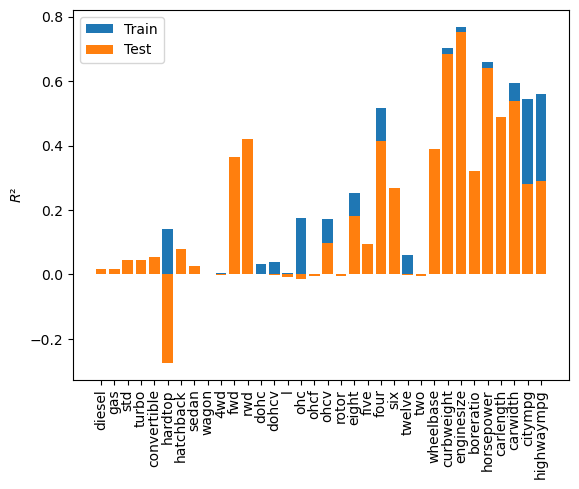

Training R² mean value 0.2182 Testing R² mean value 0.1824
Training R² max value 0.7687 Testing R² max value 0.7535


In [15]:
get_R2_features(lm)

From the above plot, we see that some individual features perform similarly to using all the features (we removed the feature `three` ), in addition, we see that smaller coefficients seem to correspond to a larger, therefore larger coefficients correspond to overfiting.

In [16]:
# Using Pipeline() function
pipe = Pipeline([
                 ('lr', LinearRegression())])

pipe.fit(X_train,y_train)
predicted = pipe.predict(X_test)


In [17]:
print("R^2 on training  data ", pipe.score(X_train, y_train))
print("R^2 on testing data ", pipe.score(X_test,y_test))

R^2 on training  data  0.9260519911659063
R^2 on testing data  0.8488476500423834


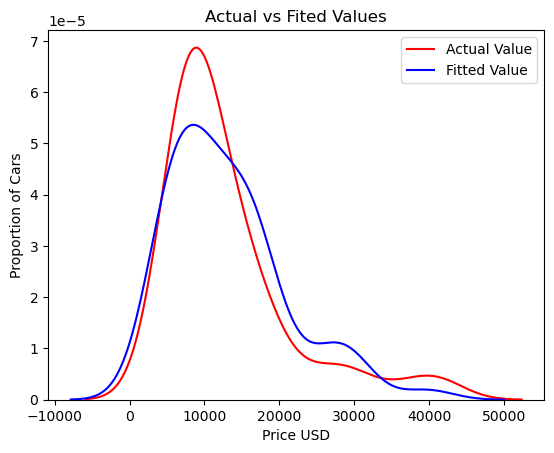

In [18]:
plot_dist(y_test, predicted)

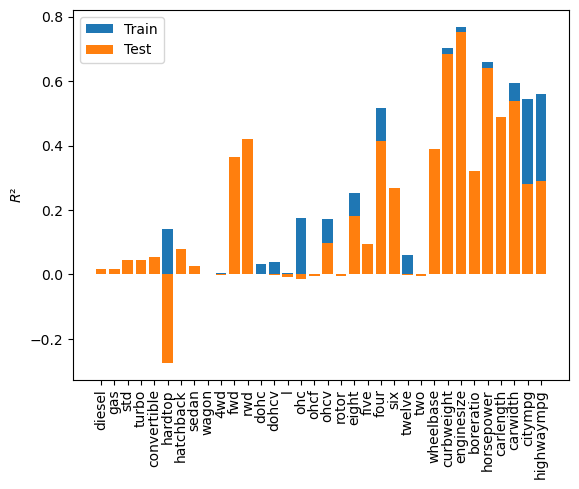

Training R² mean value 0.2182 Testing R² mean value 0.1824
Training R² max value 0.7687 Testing R² max value 0.7535


In [19]:
get_R2_features(pipe)

### Polynomial Features

### Multiple features

Polynomial transform is a simple way to increase the complexity of the model, but we must be mindful of overfilling. Below, we will perform a second degree (degree=2) polynomial transformation.

In [20]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

In [21]:
# Now, we transform the training and testing data sets
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

`X_train_poly` and `X_test_poly` now contain the original features of X plus the square of these features and the cross-terms combination. Let's check the shape of the newly created train and test sets.

In [22]:
print(X_train_poly.shape)
print(X_test_poly.shape)

(143, 665)
(62, 665)


In [23]:
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

predicted = lm.predict(X_train_poly)

In [24]:
print("R^2 on training data:", lm.score(X_train_poly, y_train))
print("R^2 on testing data:", lm.score(X_test_poly,y_test))

R^2 on training data: 0.9985318497975866
R^2 on testing data: -36729.958122784825


We see the model has a negative *R²* on the test data set, this is sign of overfiting.

### Individual Features

In [25]:
# Using pipeline
input = [('polynomial', PolynomialFeatures(include_bias=False, degree=2)),
         ('model', LinearRegression())]

In [26]:
# We can repeat the steps above, using the pipeline object
pipe = Pipeline(input)
pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [27]:
# We can see the results are identical
print("R^2 on training  data:", pipe.score(X_train, y_train))
print("R^2 on testing data:", pipe.score(X_test,y_test))

R^2 on training  data: 0.9985318497975866
R^2 on testing data: -36729.958122784825


We can train our model on each of the features using the Polynomial Feature transform of the second degree. Then we can plot our *R²*.

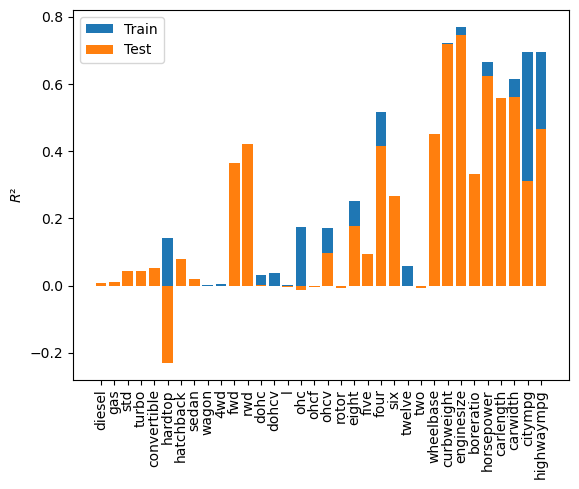

Training R² mean value 0.2307 Testing R² mean value 0.1945
Training R² max value 0.7707 Testing R² max value 0.7463


In [28]:
get_R2_features(pipe)

Feature with the max *R²* is higher than when using all the features.

### GridSearch and Pipeline
In this section of the notebook, we will define a pipeline object, then use GridSearch to find the best hyper-parameters of the model by using cross-validation method of the parameter grid, as shown in the figure below. A 5-fold cross validation is used by default. We will learn more about k-fold cross validation in the next, Cross Validation lesson of the Course.

In [29]:
# We create PolynomialFeatures() pipeline
input = [('polynomial', PolynomialFeatures(include_bias=False, degree=2)),
         ('model', LinearRegression())]

pipe = Pipeline(input)

To search for the best combination of hyperparameters, we create a **GridSearchCV** object with dictionary of parameter values. The parameters of pipelines can be set using the name of the key separated by '__', then the parameter name of the key.

In [30]:
param_grid = {'polynomial__degree' : [1, 2, 3, 4]}

search = GridSearchCV(pipe, param_grid, n_jobs=1)

search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(include_bias=False)),
                                       ('model', LinearRegression())]),
             n_jobs=1, param_grid={'polynomial__degree': [1, 2, 3, 4]})

The object finds the best parameter values on the validation data. We can obtain the estimator with the best parameters and assign it to the variable best, as follows:

In [31]:
search.best_params_

{'polynomial__degree': 1}

In [32]:
search.score(X_test, y_test)

0.8467665953994743

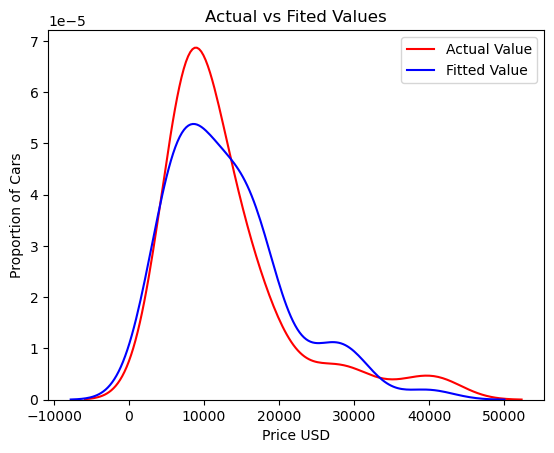

In [33]:
predicted = search.predict(X_test)
plot_dist(y_test, predicted)

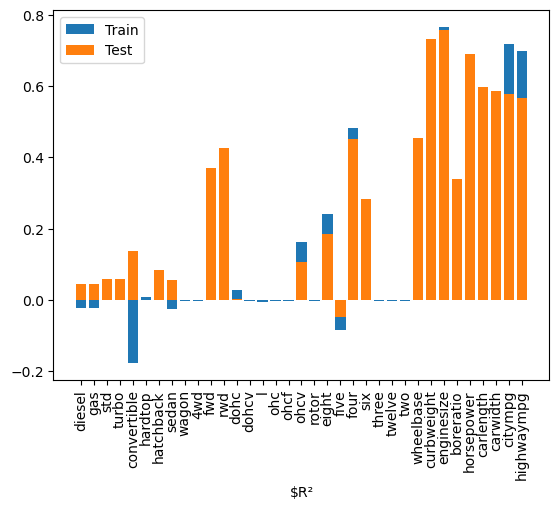

Training R^2 mean value 0.18388978303298914 Testing R^2 mean value 0.21593470041016025 
Training R^2 max value 0.7653236373791239 Testing R^2 max value 0.7565151400968062 


In [35]:
features = list(X)

R_2_train = []
R_2_test = []

for feature in features:
    param_grid = {'polynomial__degree': [1,2,3,4,5],
                  'model__positive':[True, False]}
    #'model__positive': [LinearRegression(), 'passthrough']
    input = [('polynomial', PolynomialFeatures(include_bias=False, degree=2)),
             ('model', LinearRegression())]
    pipe = Pipeline(input)

    search = GridSearchCV(pipe, param_grid, n_jobs=2)
    search.fit(X_test[[feature]], y_test)
    best = search.best_estimator_

    R_2_test.append(best.score(X_test[[feature]], y_test))
    R_2_train.append(best.score(X_train[[feature]], y_train))

plt.bar(features, R_2_train, label='Train')
plt.bar(features, R_2_test, label='Test')

plt.xticks(rotation=90)
plt.xlabel('$R²')
plt.legend()
plt.show()

print("Training R^2 mean value {} Testing R^2 mean value {} ".format(str(np.mean(R_2_train)),str(np.mean(R_2_test))) )
print("Training R^2 max value {} Testing R^2 max value {} ".format(str(np.max(R_2_train)),str(np.max(R_2_test))) )